# ML notebook to predict what stops will be dropped from a route. 

In [21]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from tqdm import tqdm
import numpy as np
from sklearn.cluster import DBSCAN
import plotly.express as px

#NEW modules: please reinstall conda env!!
#we're gonna learn the living baby jesus out of this :)
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report,ConfusionMatrixDisplay, \
                            precision_score, recall_score, f1_score, roc_auc_score,roc_curve, \
                            auc, confusion_matrix 

try:
    import tensorflow as tf
    from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
except:
    print('installing TF')
    #issue with Conda; this works
    ! pip install tensorflow
from sklearn.metrics import accuracy_score

sys.path.append('../utils')
import helpers as h
import feature_engineering as f

In [2]:
ITM_DIR = os.path.join(os.getcwd(), '../data/intermediate')

In [3]:
request_df = pd.read_csv(os.path.join(ITM_DIR, 'clean_data.csv'))

C:\Users\tinne\AppData\Local\Temp\ipykernel_41784\291413550.py:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  request_df = pd.read_csv(os.path.join(ITM_DIR, 'clean_data.csv'))


In [4]:
# add route stop distances as feature
request_df = f.calculate_distances(request_df, 'stop_order')


100%|██████████| 18010/18010 [00:14<00:00, 1285.76it/s]


In [5]:
request_df

,file_uuid,configurationName,id,lat,long,start_time,end_time,server_task_number,stop_order,dir,...,RouteId,TriggerType,ConfigurationName,NumberOfTasks,NumberOfTasksInInputPlan,request_day_route_order,request_day_route_is_last,dist_since_prev,dist_cumulative,dist_to_next_stop
610693,0000eb3f-b669-476c-bec3-858b8286e193,CreateSequence,71108,0.493993,0.315449,2022-06-09T07:30:00,2022-06-09T23:59:00,27,1,0521_612-20220609,...,0521_612,FullOptimization,CreateSequence,204.0,0.0,1.0,False,0.000000,0.000000,0.000949
610694,0000eb3f-b669-476c-bec3-858b8286e193,CreateSequence,71080,0.494289,0.314548,2022-06-09T07:30:00,2022-06-09T17:00:00,14,2,0521_612-20220609,...,0521_612,FullOptimization,CreateSequence,204.0,0.0,1.0,False,0.000949,0.000949,0.003482
610695,0000eb3f-b669-476c-bec3-858b8286e193,CreateSequence,71048,0.493936,0.311083,2022-06-09T07:30:00,2022-06-09T17:00:00,176,3,0521_612-20220609,...,0521_612,FullOptimization,CreateSequence,204.0,0.0,1.0,False,0.003482,0.004431,0.005125
610696,0000eb3f-b669-476c-bec3-858b8286e193,CreateSequence,71177,0.491165,0.315395,2022-06-09T00:00:00,2022-06-09T23:59:00,134,4,0521_612-20220609,...,0521_612,FullOptimization,CreateSequence,204.0,0.0,1.0,False,0.005125,0.009556,0.001414
610697,0000eb3f-b669-476c-bec3-858b8286e193,CreateSequence,71049,0.490411,0.316590,2022-06-09T07:30:00,2022-06-09T23:59:00,177,5,0521_612-20220609,...,0521_612,FullOptimization,CreateSequence,204.0,0.0,1.0,False,0.001414,0.010970,0.001499
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1766866,ffff6e26-f5a6-423e-b4dc-40bfd82cce12,AddToSequence,65498,0.578363,0.098513,2022-06-17T07:30:00,2022-06-17T23:59:00,100,100,0521_890-20220617,...,0521_890,AdditionalOrders,AddToSequence,104.0,102.0,2.0,False,0.000000,0.180777,0.000000
1766867,ffff6e26-f5a6-423e-b4dc-40bfd82cce12,AddToSequence,65493,0.578363,0.098513,2022-06-17T07:30:00,2022-06-17T23:59:00,101,101,0521_890-20220617,...,0521_890,AdditionalOrders,AddToSequence,104.0,102.0,2.0,False,0.000000,0.180777,0.000441
1766868,ffff6e26-f5a6-423e-b4dc-40bfd82cce12,AddToSequence,65408,0.578175,0.098912,2022-06-17T07:30:00,2022-06-17T23:59:00,102,102,0521_890-20220617,...,0521_890,AdditionalOrders,AddToSequence,104.0,102.0,2.0,False,0.000441,0.181218,0.000113
1766869,ffff6e26-f5a6-423e-b4dc-40bfd82cce12,AddToSequence,65388,0.578287,0.098896,2022-06-17T07:30:00,2022-06-17T23:59:00,103,103,0521_890-20220617,...,0521_890,AdditionalOrders,AddToSequence,104.0,102.0,2.0,False,0.000113,0.181331,0.000000


In [6]:
## add route centers as feature. 
request_df = f.get_route_center(request_df)


In [7]:
# add gets_dropped as feature. 
initial_dfs = []
for _, df in request_df.groupby('dir'):
    #Time is the timestamp coming from serverlog: compare first request wiht last non-PM request
    # REMEMBER THAT: PM requests where filtered out already.
    first_request_timestamp = df['Time'].min()
    last_request_timestamp = df['Time'].max()
    #get the first and last request as dfs: 
    first_request_df = df.loc[df['Time'] == first_request_timestamp]
    last_request_df = df.loc[df['Time'] == last_request_timestamp]
    #Only interested in dropped for generating MLs on dropping stops. 
    #TODO ==> Someone: run statistics on common, added, dropped. 
    common, added, dropped = f.stop_diffs(first_request_df, last_request_df)
    #add the column "gets_dropped" to first_request_df and set it to 1 if first_request_df.id is in dropped else 0
    first_request_df['gets_dropped'] = first_request_df['id'].apply(lambda x: 1 if x in dropped else 0)
    initial_dfs.append(first_request_df)

C:\Users\tinne\AppData\Local\Temp\ipykernel_41784\2469773114.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_request_df['gets_dropped'] = first_request_df['id'].apply(lambda x: 1 if x in dropped else 0)
C:\Users\tinne\AppData\Local\Temp\ipykernel_41784\2469773114.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_request_df['gets_dropped'] = first_request_df['id'].apply(lambda x: 1 if x in dropped else 0)
C:\Users\tinne\AppData\Local\Temp\ipykernel_41784\2469773114.py:15: SettingWithCopyW

In [8]:
initial_routes_df = pd.concat(initial_dfs)
initial_routes_df

,file_uuid,configurationName,id,lat,long,start_time,end_time,server_task_number,stop_order,dir,...,NumberOfTasksInInputPlan,request_day_route_order,request_day_route_is_last,dist_since_prev,dist_cumulative,dist_to_next_stop,mean_lat,mean_long,dst_point_to_center,gets_dropped
0,41931cd2-8975-4a64-9197-d16abe871bb7,CreateSequence,394,0.565826,0.221868,2022-06-17T07:30:00,2022-06-17T18:00:00,2,1,0521_300-20220617,...,0.0,1.0,False,0.000000,0.000000,0.000000,0.566974,0.223775,0.002225,1
1,41931cd2-8975-4a64-9197-d16abe871bb7,CreateSequence,395,0.565826,0.221868,2022-06-17T08:00:00,2022-06-17T17:00:00,1,2,0521_300-20220617,...,0.0,1.0,False,0.000000,0.000000,NaN,0.566974,0.223775,0.002225,1
6,cb9638db-2817-4ccf-b226-7775c01793a8,EstimateTime,64869,0.650488,0.296025,2022-05-30T00:00:00,2022-05-30T12:00:00,1,1,0521_301-20220530,...,154.0,1.0,True,0.000000,0.000000,0.004470,0.645124,0.305079,0.010524,0
7,cb9638db-2817-4ccf-b226-7775c01793a8,EstimateTime,64947,0.646361,0.297741,2022-05-30T00:00:00,2022-05-30T12:00:00,2,2,0521_301-20220530,...,154.0,1.0,True,0.004470,0.004470,0.000907,0.645124,0.305079,0.007442,0
8,cb9638db-2817-4ccf-b226-7775c01793a8,EstimateTime,64971,0.645787,0.298443,2022-05-30T00:00:00,2022-05-30T12:00:00,3,3,0521_301-20220530,...,154.0,1.0,True,0.000907,0.005377,0.000000,0.645124,0.305079,0.006669,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2120370,642acef2-3942-4057-aeb8-61df9f7ffa1b,CreateSequence,63656,0.484775,0.297222,2022-06-22T07:30:00,2022-06-22T23:59:00,95,131,0521_O69-20220622,...,0.0,1.0,False,0.000488,0.124391,0.001346,0.482994,0.303785,0.006801,0
2120371,642acef2-3942-4057-aeb8-61df9f7ffa1b,CreateSequence,63654,0.486119,0.297154,2022-06-22T07:30:00,2022-06-22T23:59:00,97,132,0521_O69-20220622,...,0.0,1.0,False,0.001346,0.125737,0.000954,0.482994,0.303785,0.007331,0
2120372,642acef2-3942-4057-aeb8-61df9f7ffa1b,CreateSequence,63653,0.485895,0.296226,2022-06-22T07:30:00,2022-06-22T23:59:00,98,133,0521_O69-20220622,...,0.0,1.0,False,0.000954,0.126691,0.000513,0.482994,0.303785,0.008097,0
2120373,642acef2-3942-4057-aeb8-61df9f7ffa1b,CreateSequence,63652,0.485559,0.295839,2022-06-22T07:30:00,2022-06-22T23:59:00,99,134,0521_O69-20220622,...,0.0,1.0,False,0.000513,0.127204,0.000000,0.482994,0.303785,0.008351,0


In [9]:
# # extract weekday from route_date and add as column
initial_routes_df['route_date'] = pd.to_datetime(initial_routes_df['route_date'])
initial_routes_df['weekday'] = initial_routes_df['route_date'].dt.day_name()

# change weekday to numerical value
weekday_mapping = {'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3, 'Friday': 4, 'Saturday': 5, 'Sunday': 6}
initial_routes_df['weekday'] = initial_routes_df['weekday'].map(weekday_mapping)

## ML Phase: 

In [10]:
models = {}

Feature engineering done; let's see what we're dealing with.

In [11]:
initial_routes_df.gets_dropped.mean()
#14.5% of initial route stops get dropped

0.1455619853493942

In [12]:
# Only keep needed columns into ml_df 
ml_df = initial_routes_df[['lat', 'long', 'stop_order','weekday' , 'dist_since_prev', 
                          'dist_cumulative', 'dist_to_next_stop', 'mean_lat',
                          'mean_long', 'dst_point_to_center', 'gets_dropped']]

In [13]:
#scaling not really needed here it's all done already. 
ml_df

,lat,long,stop_order,weekday,dist_since_prev,dist_cumulative,dist_to_next_stop,mean_lat,mean_long,dst_point_to_center,gets_dropped
0,0.565826,0.221868,1,4,0.000000,0.000000,0.000000,0.566974,0.223775,0.002225,1
1,0.565826,0.221868,2,4,0.000000,0.000000,NaN,0.566974,0.223775,0.002225,1
6,0.650488,0.296025,1,0,0.000000,0.000000,0.004470,0.645124,0.305079,0.010524,0
7,0.646361,0.297741,2,0,0.004470,0.004470,0.000907,0.645124,0.305079,0.007442,0
8,0.645787,0.298443,3,0,0.000907,0.005377,0.000000,0.645124,0.305079,0.006669,0
...,...,...,...,...,...,...,...,...,...,...,...
2120370,0.484775,0.297222,131,2,0.000488,0.124391,0.001346,0.482994,0.303785,0.006801,0
2120371,0.486119,0.297154,132,2,0.001346,0.125737,0.000954,0.482994,0.303785,0.007331,0
2120372,0.485895,0.296226,133,2,0.000954,0.126691,0.000513,0.482994,0.303785,0.008097,0
2120373,0.485559,0.295839,134,2,0.000513,0.127204,0.000000,0.482994,0.303785,0.008351,0


In [14]:
#shuffle df: 
ml_df = ml_df.sample(frac=1).reset_index(drop=True)

In [15]:
#Train test split with a validation set! (strafied based on target (gets_dropped))
y_name = 'gets_dropped'
train_ratio = 70
test_ratio = 20
validation_ratio = 10
stratcols = [y_name]    #stratify on target only
train_df, test_df, validation_df = h.train_test_val_splitter(
                                ml_df, 
                                train_ratio,
                                test_ratio,
                                validation_ratio, 
                                stratcols
                            )

X_train, y_train = h.get_X_y(train_df, y_name)
X_test, y_test = h.get_X_y(test_df, y_name)
#DON'T TOUCH X_val and y_val now!!!!
X_val, y_val = h.get_X_y(validation_df, y_name)
#TODO use validation set in final model comparison. 

In [17]:
# replace missing values with 0
X_test.fillna(0, inplace=True)
X_train.fillna(0, inplace=True)

## Evaluate various classification models side by side

In [18]:
models={
    "Logisitic Regression":LogisticRegression(),
    "Decision Tree":DecisionTreeClassifier(),
    "Random Forest":RandomForestClassifier(),
    "Gradient Boost":GradientBoostingClassifier(),
    "Adaboost":AdaBoostClassifier(),
    "Xgboost":XGBClassifier()
}
for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train) # Train model

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Training set performance
    model_train_accuracy = accuracy_score(y_train, y_train_pred) # Calculate Accuracy
    model_train_f1 = f1_score(y_train, y_train_pred, average='weighted') # Calculate F1-score
    model_train_precision = precision_score(y_train, y_train_pred) # Calculate Precision
    model_train_recall = recall_score(y_train, y_train_pred) # Calculate Recall
    model_train_rocauc_score = roc_auc_score(y_train, y_train_pred)


    # Test set performance
    model_test_accuracy = accuracy_score(y_test, y_test_pred) # Calculate Accuracy
    model_test_f1 = f1_score(y_test, y_test_pred, average='weighted') # Calculate F1-score
    model_test_precision = precision_score(y_test, y_test_pred) # Calculate Precision
    model_test_recall = recall_score(y_test, y_test_pred) # Calculate Recall
    model_test_rocauc_score = roc_auc_score(y_test, y_test_pred) #Calculate Roc


    print(list(models.keys())[i])
    
    print('Model performance for Training set')
    print("- Accuracy: {:.4f}".format(model_train_accuracy))
    print('- F1 score: {:.4f}'.format(model_train_f1))
    
    print('- Precision: {:.4f}'.format(model_train_precision))
    print('- Recall: {:.4f}'.format(model_train_recall))
    print('- Roc Auc Score: {:.4f}'.format(model_train_rocauc_score))

    
    
    print('----------------------------------')
    
    print('Model performance for Test set')
    print('- Accuracy: {:.4f}'.format(model_test_accuracy))
    print('- F1 score: {:.4f}'.format(model_test_f1))
    print('- Precision: {:.4f}'.format(model_test_precision))
    print('- Recall: {:.4f}'.format(model_test_recall))
    print('- Roc Auc Score: {:.4f}'.format(model_test_rocauc_score))

    
    print('='*35)
    print('\n')

c:\Users\tinne\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logisitic Regression
Model performance for Training set
- Accuracy: 0.8555
- F1 score: 0.7931
- Precision: 0.6135
- Recall: 0.0193
- Roc Auc Score: 0.5086
----------------------------------
Model performance for Test set
- Accuracy: 0.8558
- F1 score: 0.7942
- Precision: 0.6274
- Recall: 0.0228
- Roc Auc Score: 0.5103


Decision Tree
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 0.9998
- Roc Auc Score: 0.9999
----------------------------------
Model performance for Test set
- Accuracy: 0.9159
- F1 score: 0.9162
- Precision: 0.7078
- Recall: 0.7189
- Roc Auc Score: 0.8342


Random Forest
Model performance for Training set
- Accuracy: 0.9999
- F1 score: 0.9999
- Precision: 1.0000
- Recall: 0.9996
- Roc Auc Score: 0.9998
----------------------------------
Model performance for Test set
- Accuracy: 0.9430
- F1 score: 0.9391
- Precision: 0.9182
- Recall: 0.6677
- Roc Auc Score: 0.8288


Gradient Boost
Model performance for Training se

In [ ]:
## Hyperparameter Training
rf_params = {"max_depth": [5, 8, 15, None, 10],
             "max_features": [5, 7, "auto", 8],
             "min_samples_split": [2, 8, 15, 20],
             "n_estimators": [100, 200, 500, 1000]}
dt_params = {'criterion':['gini','entropy', 'log_loss'],
            'splitter':['best','random'],
            'max_depth':[1,2,3,4,5],
             'max_features':['auto','sqrt','log2']}
xgboost_params = {"learning_rate": [0.1, 0.01],
                  "max_depth": [5, 8, 12, 20, 30],
                  "n_estimators": [100, 200, 300],
                  "colsample_bytree": [0.5, 0.8, 1, 0.3, 0.4]}

In [ ]:
# Models list for Hyperparameter tuning
randomcv_models = [
    ("RF", RandomForestClassifier(), rf_params),
    ("DecisionTree", DecisionTreeClassifier(), dt_params),
    ("XGBoost", XGBClassifier(), xgboost_params)]

In [ ]:
model_param = {}
for name, model, params in randomcv_models:
    random = RandomizedSearchCV(estimator=model,
                                   param_distributions=params,
                                   n_iter=100,
                                   cv=3,
                                   verbose=2,
                                   n_jobs=-1)
    random.fit(X_train, y_train)
    model_param[name] = random.best_params_

for model_name in model_param:
    print(f"---------------- Best Params for {model_name} -------------------")
    print(model_param[model_name])

## Random Search CV results
#### ---------------- Best Params for RF -------------------

{'n_estimators': 1000, 'min_samples_split': 2, 'max_features': 8, 'max_depth': None}

#### ---------------- Best Params for DecisionTree -------------------

{'splitter': 'best', 'max_features': 'sqrt', 'max_depth': 5, 'criterion': 'entropy'}

#### ---------------- Best Params for Xgboost -------------------

{'n_estimators': 200, 'max_depth': 30, 'learning_rate': 0.1, 'colsample_bytree': 0.8}

Random Forest
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 0.9998
- Roc Auc Score: 0.9999
----------------------------------
Model performance for Test set
- Accuracy: 0.9461
- F1 score: 0.9432
- Precision: 0.9077
- Recall: 0.7013
- Roc Auc Score: 0.8446




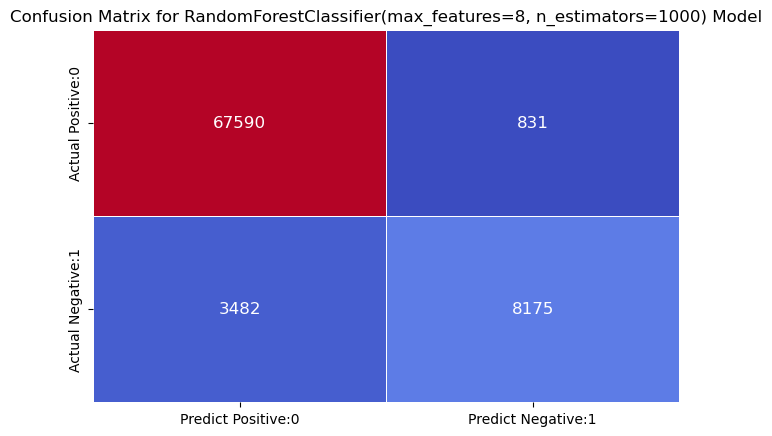

Decision Tree
Model performance for Training set
- Accuracy: 0.8661
- F1 score: 0.8316
- Precision: 0.6475
- Recall: 0.1758
- Roc Auc Score: 0.5797
----------------------------------
Model performance for Test set
- Accuracy: 0.8662
- F1 score: 0.8317
- Precision: 0.6494
- Recall: 0.1758
- Roc Auc Score: 0.5798




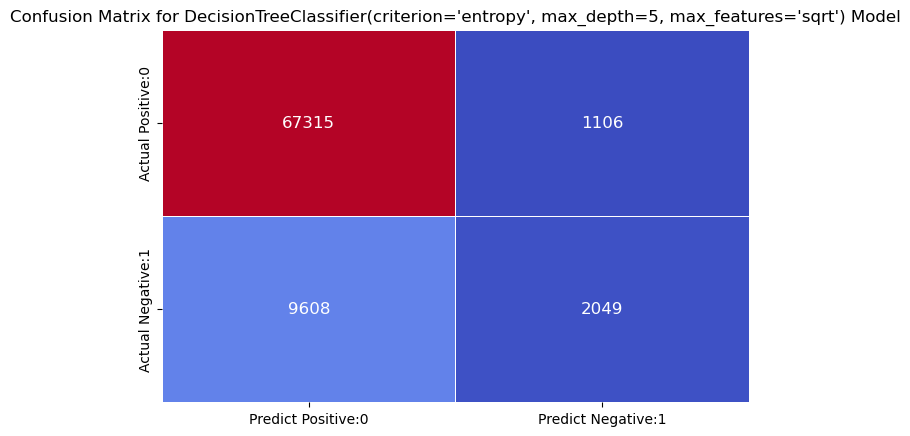

c:\Users\tinne\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [09:22:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Xgboost
Model performance for Training set
- Accuracy: 0.9998
- F1 score: 0.9998
- Precision: 0.9997
- Recall: 0.9988
- Roc Auc Score: 0.9994
----------------------------------
Model performance for Test set
- Accuracy: 0.9464
- F1 score: 0.9434
- Precision: 0.9094
- Recall: 0.7016
- Roc Auc Score: 0.8448




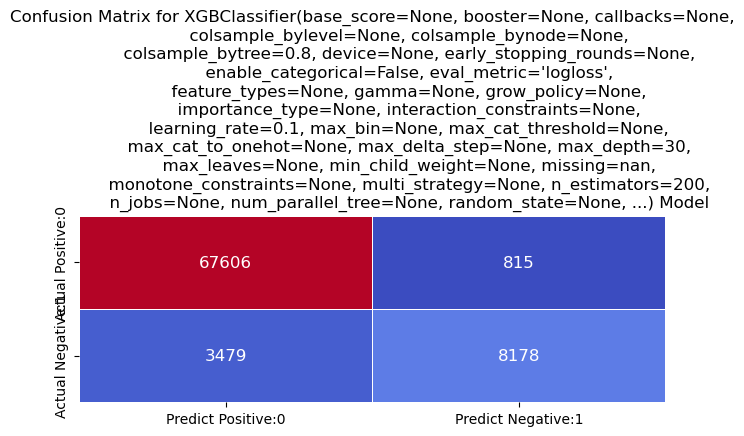

In [ ]:
models={
    "Random Forest":RandomForestClassifier(n_estimators=1000,min_samples_split=2,
                                          max_features=8,max_depth=None),
    "Decision Tree": DecisionTreeClassifier(splitter='best', max_features='sqrt',
                                            max_depth=5, criterion='entropy'),
    "Xgboost":XGBClassifier(n_estimators=200,max_depth=30,learning_rate=0.1,
                                colsample_bytree=0.8,objective="binary:logistic", 
                                eval_metric="logloss", 
                                use_label_encoder=False),
}

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train) # Train model

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Training set performance
    model_train_accuracy = accuracy_score(y_train, y_train_pred) # Calculate Accuracy
    model_train_f1 = f1_score(y_train, y_train_pred, average='weighted') # Calculate F1-score
    model_train_precision = precision_score(y_train, y_train_pred) # Calculate Precision
    model_train_recall = recall_score(y_train, y_train_pred) # Calculate Recall
    model_train_rocauc_score = roc_auc_score(y_train, y_train_pred)


    # Test set performance
    model_test_accuracy = accuracy_score(y_test, y_test_pred) # Calculate Accuracy
    model_test_f1 = f1_score(y_test, y_test_pred, average='weighted') # Calculate F1-score
    model_test_precision = precision_score(y_test, y_test_pred) # Calculate Precision
    model_test_recall = recall_score(y_test, y_test_pred) # Calculate Recall
    model_test_rocauc_score = roc_auc_score(y_test, y_test_pred) #Calculate Roc


    print(list(models.keys())[i])
    
    print('Model performance for Training set')
    print("- Accuracy: {:.4f}".format(model_train_accuracy))
    print('- F1 score: {:.4f}'.format(model_train_f1))
    
    print('- Precision: {:.4f}'.format(model_train_precision))
    print('- Recall: {:.4f}'.format(model_train_recall))
    print('- Roc Auc Score: {:.4f}'.format(model_train_rocauc_score))

    
    
    print('----------------------------------')
    
    print('Model performance for Test set')
    print('- Accuracy: {:.4f}'.format(model_test_accuracy))
    print('- F1 score: {:.4f}'.format(model_test_f1))
    print('- Precision: {:.4f}'.format(model_test_precision))
    print('- Recall: {:.4f}'.format(model_test_recall))
    print('- Roc Auc Score: {:.4f}'.format(model_test_rocauc_score))

    
    print('='*35)
    print('\n')

    cm = confusion_matrix(y_test, y_test_pred)

    cm_matrix = pd.DataFrame(data=cm, index=['Actual Positive:0', 'Actual Negative:1'], 
                                    columns=['Predict Positive:0', 'Predict Negative:1'])


    sns.heatmap(cm_matrix, annot=False, fmt='d', cmap='coolwarm',
                cbar=False, linewidths=0.5)

    # Manually add text annotations as seaborn was not showing bottom text
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            value = cm[i, j]
            plt.text(j + 0.5, i + 0.5, str(value),
                    ha='center', va='center',
                    fontsize=12, color='white')
            
    plt.title(f"Confusion Matrix for {list(models.keys())[i]}")
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15)
    plt.show()

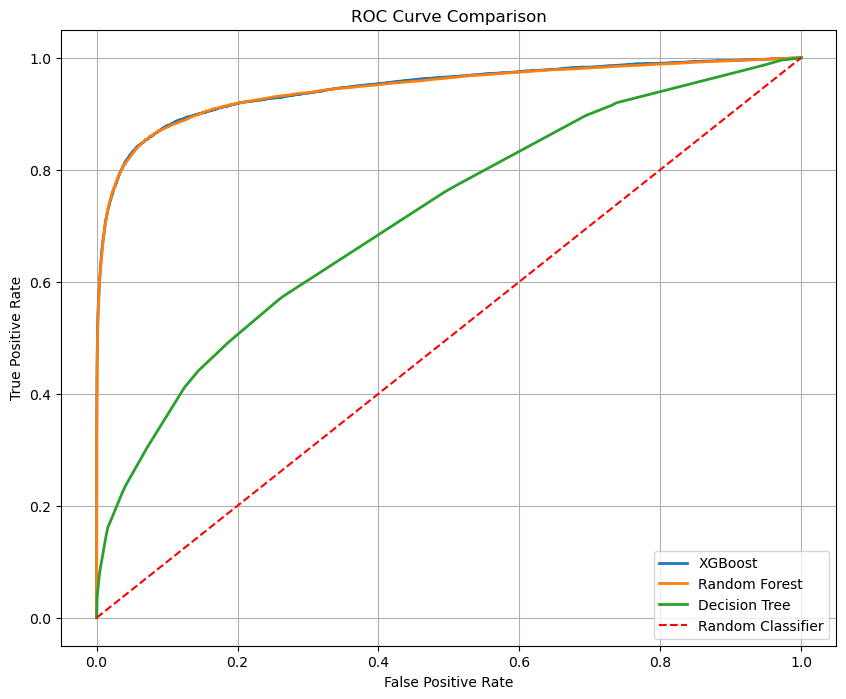

In [42]:
## Plot ROC AUC Curve
plt.figure(figsize=(10, 8))

# Add the models to the list that you want to view on the ROC plot
auc_models = [{
    'label': 'XGBoost',
    'model': XGBClassifier(n_estimators=200, max_depth=30, learning_rate=0.1,
                           colsample_bytree=0.8)
},
{
    'label': 'Random Forest',
    'model': RandomForestClassifier(n_estimators=1000, min_samples_split=2,
                                    max_features=8, max_depth=None)
},
{
    'label': 'Decision Tree',
    'model': DecisionTreeClassifier(splitter='best', max_features='sqrt',
                                    max_depth=5, criterion='entropy')
}]

# Create loop through all models
for algo in auc_models:
    model = algo['model']  # Select the model
    model.fit(X_train, y_train)  # Train the model
    
    # Compute False positive rate and True positive rate
    y_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    
    # Plot the ROC curve
    plt.plot(fpr, tpr, lw=2, label=f'{algo["label"]}')

# Plot the diagonal line
plt.plot([0, 1], [0, 1], 'r--', label='Random Classifier')

# Add labels, title, and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid()
plt.show()